In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, precision_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
df = pd.read_csv(r"C:\Users\kasar\Downloads\telco1.csv")

In [6]:
print(df.head())
print(df.info())
print(df.describe())

   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

In [7]:
df.drop_duplicates(inplace=True)

In [8]:
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [9]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(df['TotalCharges'].mean(), inplace=True)

C:\Users\kasar\AppData\Local\Temp\ipykernel_21712\3872007994.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(df['TotalCharges'].mean(), inplace=True)


In [10]:
df.drop('customerID', axis=1, inplace=True)

In [11]:
cat_cols = df.select_dtypes(include=['object']).columns
cat_cols = cat_cols.drop('Churn')

In [12]:
le = LabelEncoder()
for col in cat_cols:
    if df[col].nunique() <= 2:
        df[col] = le.fit_transform(df[col])

In [13]:
df = pd.get_dummies(df, columns=[col for col in cat_cols if df[col].nunique() > 2])


In [14]:
df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})

In [15]:
X = df.drop('Churn', axis=1)
y = df['Churn']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [17]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [18]:
baseline_model = RandomForestClassifier(random_state=42)
baseline_model.fit(X_train, y_train)
y_pred_base = baseline_model.predict(X_test)

In [19]:
acc_base = accuracy_score(y_test, y_pred_base)
cm_base = confusion_matrix(y_test, y_pred_base)
recall_churn_base = recall_score(y_test, y_pred_base)

In [20]:
print("=== Baseline Random Forest ===")
print("Accuracy:", acc_base)
print("Confusion Matrix:\n", cm_base)
print("Recall (Churn Customers):", recall_churn_base)

=== Baseline Random Forest ===
Accuracy: 0.7792760823278921
Confusion Matrix:
 [[912 123]
 [188 186]]
Recall (Churn Customers): 0.49732620320855614


In [25]:
ada_model = AdaBoostClassifier(
    estimator=RandomForestClassifier(max_depth=3, random_state=42),  # Latest scikit-learn uses 'estimator'
    n_estimators=50,
    learning_rate=1.0,
    random_state=42
)
ada_model.fit(X_train, y_train)
y_pred_ada = ada_model.predict(X_test)

In [26]:
print("\n=== AdaBoost Ensemble ===")
print("Accuracy:", accuracy_score(y_test, y_pred_ada))
print("Precision:", precision_score(y_test, y_pred_ada))
print("Recall:", recall_score(y_test, y_pred_ada))
print("F1-Score:", f1_score(y_test, y_pred_ada))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_ada))
print(classification_report(y_test, y_pred_ada))


=== AdaBoost Ensemble ===
Accuracy: 0.7785663591199432
Precision: 0.6076388888888888
Recall: 0.4679144385026738
F1-Score: 0.5287009063444109
Confusion Matrix:
 [[922 113]
 [199 175]]
              precision    recall  f1-score   support

           0       0.82      0.89      0.86      1035
           1       0.61      0.47      0.53       374

    accuracy                           0.78      1409
   macro avg       0.72      0.68      0.69      1409
weighted avg       0.77      0.78      0.77      1409



In [27]:
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

C:\Users\kasar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:199: UserWarning: [15:04:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [28]:
print("\n=== XGBoost Ensemble ===")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("Precision:", precision_score(y_test, y_pred_xgb))
print("Recall:", recall_score(y_test, y_pred_xgb))
print("F1-Score:", f1_score(y_test, y_pred_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))


=== XGBoost Ensemble ===
Accuracy: 0.8076650106458482
Precision: 0.6757679180887372
Recall: 0.5294117647058824
F1-Score: 0.5937031484257871
Confusion Matrix:
 [[940  95]
 [176 198]]
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1035
           1       0.68      0.53      0.59       374

    accuracy                           0.81      1409
   macro avg       0.76      0.72      0.73      1409
weighted avg       0.80      0.81      0.80      1409



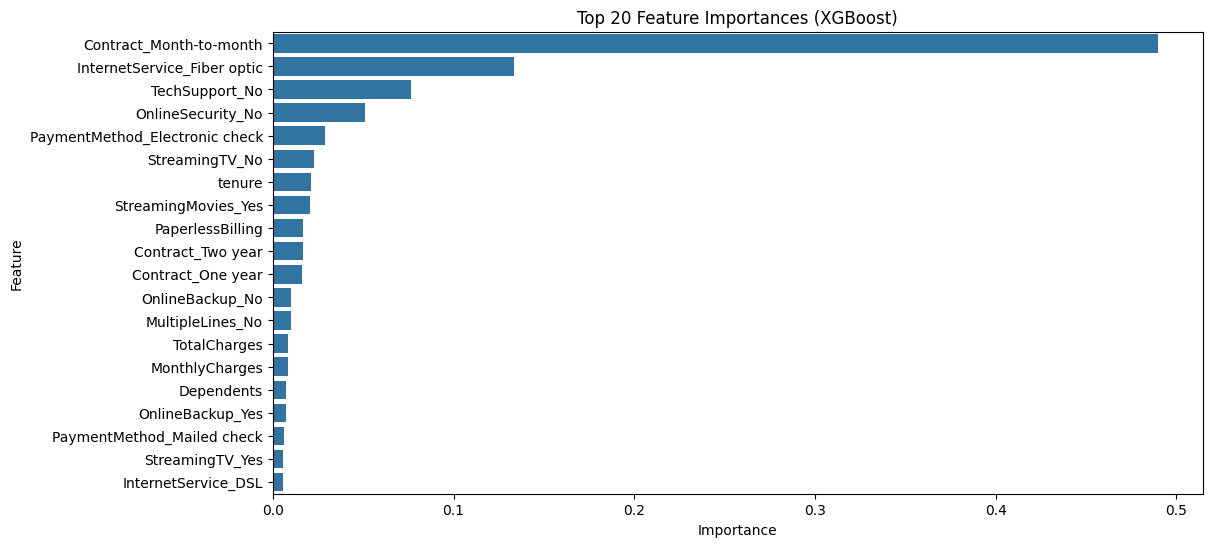

In [29]:
importance = xgb_model.feature_importances_
features = X.columns
feat_imp = pd.DataFrame({'Feature': features, 'Importance': importance})
feat_imp.sort_values(by='Importance', ascending=False, inplace=True)

plt.figure(figsize=(12,6))
sns.barplot(x='Importance', y='Feature', data=feat_imp.head(20))
plt.title("Top 20 Feature Importances (XGBoost)")
plt.show()
